In [1]:
#!pip install gensim

In [2]:
import pandas as pd
data = pd.read_csv('./1-1.csv',encoding='gb18030')
print(data.shape)
data.head(1)

(5677, 3)


,order_id,user_name,content
0,1,-精緻的豬豬女戰士-,#你好2020#新年第一天元气满满的早起出门买早饭结果高估了自己抗冻能力回家成功冻发烧（大概...


In [3]:
# 加载词性标注模块
import jieba.posseg
# 加载词向量训练模块
from gensim import models, similarities
from gensim.models import Word2Vec
# 添加 notebook 可视化模块
from tqdm.notebook import tqdm

C:\Users\sievier\anaconda3\envs\py\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [4]:
list(jieba.posseg.cut('新冠疫情'))

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\sievier\AppData\Local\Temp\jieba.cache
Loading model cost 0.696 seconds.
Prefix dict has been built successfully.


[pair('新冠', 'n'), pair('疫情', 'n')]

In [5]:
# 收集用户评论中的长度大于 1 的名词
n_word = list()
# 将用户评论转换为 list 的形式
sentence_list = data['content'].astype(str).tolist()
# 实时显示处理状态
for sentence in tqdm(sentence_list):
    tmp = list()
    for word, flag in jieba.posseg.cut(sentence):
        if 'n' in flag and len(word) > 1:
            tmp.append(word)
    n_word.append(tmp)

  0%|          | 0/5677 [00:00<?, ?it/s]

In [6]:
# size 为词向量维度数,min_count 为统计词频出现的最小词频数,其余参数使用默认
sizes = 300
model = models.word2vec.Word2Vec(n_word,vector_size = sizes,min_count=1)

In [7]:
# 输入测试用例
keys = '口罩'
topn = 5
# most_similar 就是通过找到词语向量并计算向量余弦相似度，找到最近的 topn 的词语
model.wv.most_similar(positive=[keys], topn=topn)

[('全文', 0.9999424815177917),
 ('病毒', 0.999928891658783),
 ('医疗', 0.9999166131019592),
 ('症状', 0.9999143481254578),
 ('情况', 0.9999082684516907)]

In [8]:
words = '病毒'
model.wv[words].shape

(300,)

In [9]:
# 提取全部的词
words_list = list(model.wv.key_to_index)
word_vector = model.wv[words_list]
# 打印主题词典的个数
len(word_vector)

8760

In [12]:
# 加载 KMeans 聚类算法模块
from sklearn.cluster import KMeans

# 加载画图模块
import matplotlib.pyplot as plt
%matplotlib inline

  0%|          | 0/20 [00:00<?, ?it/s]

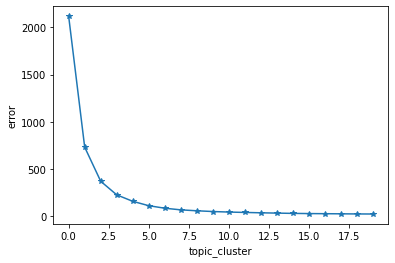

In [13]:
# SSE 是所有样本的聚类误差，代表了聚类效果的好坏，sse_error_list 存放每次结果的误差平方和
sse_error_list = list()
# 设置最大的聚类中心点个数

cluster_max = 20
# 实时显示聚类训练的情况

for clusters in tqdm(range(1, cluster_max + 1)):
    # 构造聚类器，只改变聚类个数，其余均使用默认配置
    clf = KMeans(n_clusters=clusters)
    # 开始训练模型
    clf.fit(word_vector)
    sse_error_list.append(clf.inertia_)

# 横坐标表示聚类个数
plt.xlabel('topic_cluster')

# 纵坐标表示误差
plt.ylabel('error')

# 对聚类点进行显示设置
plt.plot(sse_error_list, '*-')

# 对聚类结果进行可视化
plt.show()

In [14]:
sse_error_mean = sum(sse_error_list) / len(sse_error_list)
sse_error_mean

213.6922287940979

In [15]:
# 定义处理函数
def get_best_clusters(sse_error_list):
    # 通过均值来判断肘部的点,index 从 0 开始
    for index, value in enumerate(sse_error_list):
        if sse_error_mean > value:
            # 返回不超过均值点的下一个聚类索引即可
            return index + 2

In [16]:
best_topic_cluster = get_best_clusters(sse_error_list)
best_topic_cluster

6

In [17]:
# 使用最佳的聚类个数初始化模型，其余使用默认设置
clf = KMeans(n_clusters=best_topic_cluster)

In [18]:
topic_cluster_labels = clf.fit_predict(word_vector)

In [19]:
cluster_centers_list = clf.cluster_centers_
len(cluster_centers_list)

6

In [20]:
import numpy as np
# 存储计算的欧式距离
cal_EuclideanDistance = list()

for index, words in tqdm(list(enumerate(words_list))):
    # 取出词的词向量
    words_vec = model.wv[words]
    # 取出词的聚类中心点的向量
    center_vec = cluster_centers_list[topic_cluster_labels[index]]
    # 计算词向量到聚类中心点的欧式距离
    dist = np.sqrt(np.sum(np.square(words_vec - center_vec)))
    cal_EuclideanDistance.append(dist)

  0%|          | 0/8760 [00:00<?, ?it/s]

In [21]:
# 设置 DataFrame 的列名
topic_cluster_data = pd.DataFrame({
    'words': words_list,
    'topic_cluster': topic_cluster_labels,
    'euclidean_distance': cal_EuclideanDistance
})

# 显示前几行数据
topic_cluster_data.head()

,words,topic_cluster,euclidean_distance
0,老板,1,0.370542
1,房间,1,0.661859
2,酒店,1,0.584855
3,热情,2,0.549656
4,环境,2,0.265376


In [22]:
topic_cluster_data['topic_cluster'].unique()

array([1, 2, 4, 5, 3, 0])

In [23]:
#热度评估
topic_cluster_data['topic_cluster'].groupby(
    topic_cluster_data['topic_cluster']).count()

topic_cluster
0    6913
1      59
2     136
3    1246
4      17
5     389
Name: topic_cluster, dtype: int64

In [24]:
# 按照词与中心点的欧式距离进行降序排列
def get_top_cluster_words(topic_cluster_labels, topn=20):
    # 定义主题和主题词的存储结构
    cluster_result = dict()

    # 分别处理每个主题下的主题词并按照主题词与主题中心的欧式距离尽心倒序处理
    for topic_cluster_label in topic_cluster_labels:
        topic_select = topic_cluster_data[topic_cluster_data['topic_cluster'] ==
                                          topic_cluster_label].sort_values(
            by=["euclidean_distance"],
            ascending=False)
        # 输出每个主题下的 topn 的主题词
        cluster_result[topic_cluster_label] = topic_select['words'].tolist()[
            :topn]
    return cluster_result

In [25]:
topic_cluster_labels_list = list(range(best_topic_cluster))
topic_cluster_labels_list

[0, 1, 2, 3, 4, 5]

In [26]:
# 设定每一个主题显示 topn 的词语
topn = 30
topic_result = get_top_cluster_words(topic_cluster_labels_list, topn=topn)
# 打印每个主题下的词语
for topic_num, topic_words in topic_result.items():
    print('主题 # {}- 主题词: {}'.format(topic_num, topic_words))

主题 # 0- 主题词: ['亮堂', '差价', '降价', '博主', '断语', '体质', '商务部', '拜托', '患病', '国学', '产物', '小虫子', '名义', '尊巴', '易凡', '咸菜', '阵雨', '盒子', '栏目', '检察机关', '楼台', '苏州', '霓虹', '用具', '联票', '未央', '小孩子', '迎新春', '客户端', '防盗锁']
主题 # 1- 主题词: ['网页', '问题', '视频', '国家', '重症', '出院', '社区', '旅游', '专家', '重庆', '医护人员', '链接', '房间', '建议', '价格', '院士', '收费站', '免费', '医疗', '南门', '酒店', '开学', '时候', '热水', '朋友', '症状', '情况', '早餐', '味道', '小区']
主题 # 2- 主题词: ['战疫', '病人', '中医药', '公共卫生', '电话', '卫生', '厕所', '抗击', '住宿', '人民', '卫生间', '抗疫', '报告', '家庭', '医务人员', '热情', '态度', '丁香', '服务', '步行', '总体', '方面', '个人', '祝福', '妈妈', '院长', '窗户', '条件', '中心', '效果']
主题 # 3- 主题词: ['家长', '百度', '系统', '音乐', '李圆霸', '垃圾', '战斗', '马桶', '世界卫生组织', '现场', '家属', '心脏', '血管', '市长', '病房', '江西', '防治法', '买票', '联欢会', '河北', '大队', '任务', '阻击战', '照片', '洗手间', '用餐', '资金', '案例', '大量', '单人间']
主题 # 4- 主题词: ['疫情', '病毒', '大家', '防控', '医院', '生活', '湖北', '中国', '工作', '患者', '武汉', '时间', '肺炎', '病例', '医生', '口罩', '全文']
主题 # 5- 主题词: ['学生', '父母', '人们', '客人', '门诊', '儿子', '能量', '太帅', '一家人', '空气', '众志成城'